<a href="https://colab.research.google.com/github/Alejix/DataScience/blob/main/Time_Series_Analysis_Adjusting_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.9 MB/s eta 0:00:00


#Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.signal import savgol_filter

#Suavización Exponencial
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#SARIMAX
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Configuración de advertencias y gráficos

In [ ]:
warnings.filterwarnings('ignore')
plt.style.use('bmh')

#Carga de datos

In [ ]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [ ]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [ ]:
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,165,165,165,165,165,165,165,165,165,165
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933


Transformación de datos a serie de tiempo

In [ ]:
cols = confirmed_df.keys()
cols

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '2/28/23', '3/1/23', '3/2/23', '3/3/23', '3/4/23', '3/5/23', '3/6/23',
       '3/7/23', '3/8/23', '3/9/23'],
      dtype='object', length=1147)

In [ ]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [ ]:
dates = confirmed.keys()
dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '2/28/23', '3/1/23', '3/2/23', '3/3/23', '3/4/23', '3/5/23', '3/6/23',
       '3/7/23', '3/8/23', '3/9/23'],
      dtype='object', length=1143)

In [ ]:
#Creación de series de tiempo (acumuladas)
world_cases = []
total_deaths = []
mortality_rate = []

for i in dates:
  confirmed_sum = confirmed[i].sum()
  death_sum = deaths[i].sum()
  world_cases.append(confirmed_sum)
  total_deaths.append(death_sum)
  mortality_rate.append(death_sum/confirmed_sum)

world_cases_df = pd.DataFrame([dates, world_cases])
world_cases_df = world_cases_df.transpose()
world_cases_df.columns = ['dates', 'cases']

total_deaths_df = pd.DataFrame([dates, total_deaths])
total_deaths_df = total_deaths_df.transpose()
total_deaths_df.columns = ['dates', 'deaths']

mortality_rate_df = pd.DataFrame([dates, mortality_rate])
mortality_rate_df = mortality_rate_df.transpose()
mortality_rate_df.columns = ['dates', 'mortality_rate']

In [ ]:
world_cases_df

,dates,cases
0,1/22/20,557
1,1/23/20,657
2,1/24/20,944
3,1/25/20,1437
4,1/26/20,2120
...,...,...
1138,3/5/23,676024901
1139,3/6/23,676082941
1140,3/7/23,676213378
1141,3/8/23,676392824


Gráfico de las series

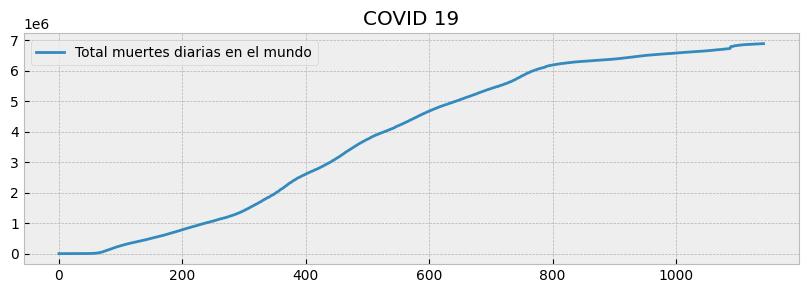

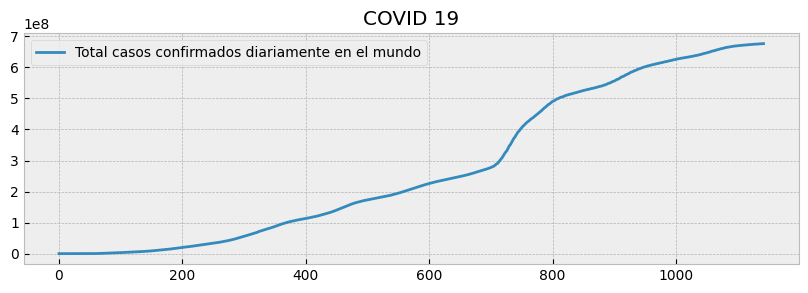

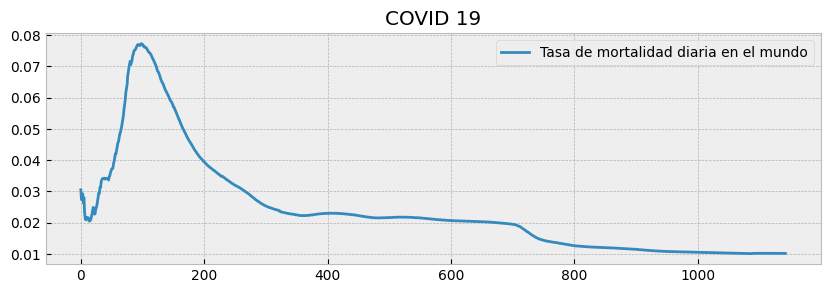

In [ ]:
plt.figure(figsize = (10,3))
plt.plot(total_deaths_df.deaths, label = 'Total muertes diarias en el mundo')
plt.title('COVID 19')
plt.legend()
plt.show()

plt.figure(figsize = (10,3))
plt.plot(world_cases_df.cases, label = 'Total casos confirmados diariamente en el mundo')
plt.title('COVID 19')
plt.legend()
plt.show()

plt.figure(figsize = (10,3))
plt.plot(mortality_rate_df.mortality_rate, label = 'Tasa de mortalidad diaria en el mundo')
plt.title('COVID 19')
plt.legend()
plt.show()

Función para calcular los incrementos diarios

In [ ]:
def daily_increase(data):
  d = []
  for i in range(len(data)):
    if i == 0:
      d.append(data[0])
    else:
      d.append(data[i] - data[i -1])
  return d

Función de filtrado

In [ ]:
def maFilter(x, N):
  xTemp = np.zeros(len(x) + (N - 1))
  xTemp[(N - 1):] = x
  y = np.zeros(len(x))

  for i in range(0, len(x)):
    y[i] = xTemp[i : i + N].sum()/float(N)
  return y

Es bueno filtrar el ruido porque una serie con mucho ruido me puede generar una formula de predicción que no funcione. Para esto suavizamos la serie, realizamos una predicción no tan exacta y posteriormente le agregamos el ruido a dicha predicción.

In [ ]:
window = 7 #Numero de dias a analizar
#Casos
world_daily_increase = daily_increase(world_cases_df.cases)
world_daily_increase_avg = maFilter(world_daily_increase, window)

#Muertes
world_daily_deaths = daily_increase(total_deaths_df.deaths)
world_daily_deaths_avg = maFilter(world_daily_deaths, window)

[]

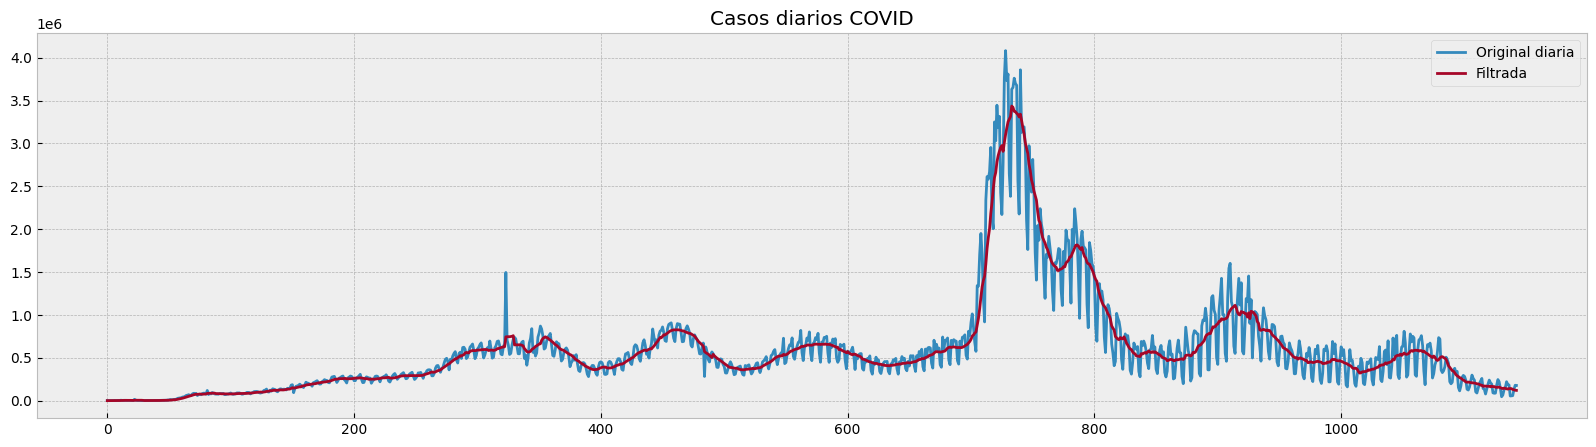

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(world_daily_increase, label = "Original diaria")
plt.plot(world_daily_increase_avg, label = "Filtrada")
plt.title('Casos diarios COVID')
plt.legend()
plt.plot()

[]

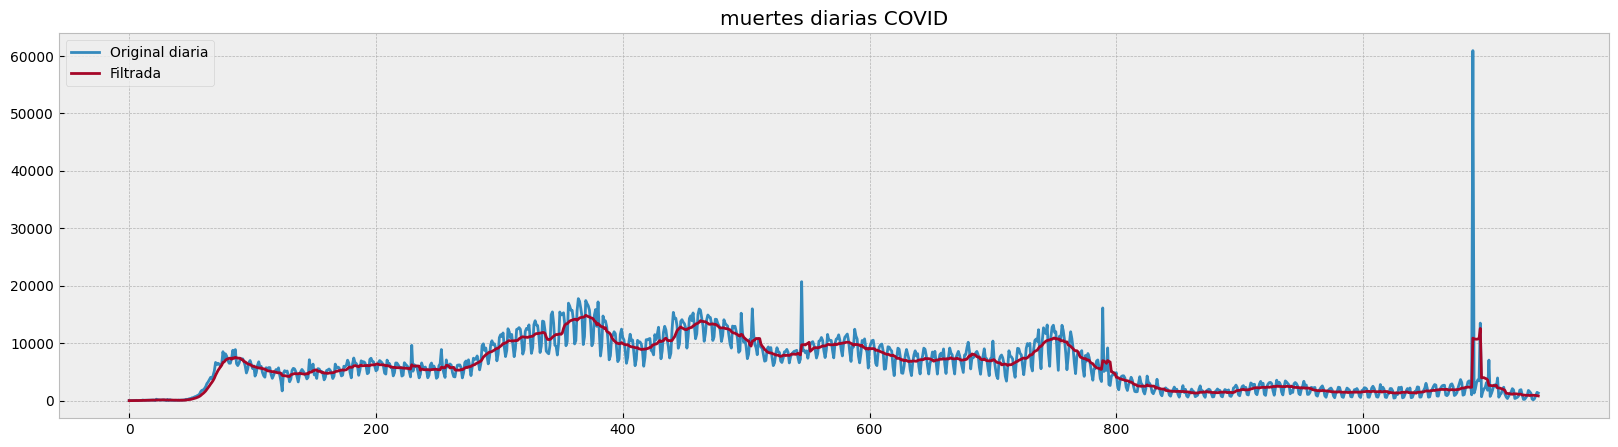

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(world_daily_deaths, label = "Original diaria")
plt.plot(world_daily_deaths_avg, label = "Filtrada")
plt.title('muertes diarias COVID')
plt.legend()
plt.plot()

#Suavización exponencial simple

In [ ]:
def exponential_smoothing(series, alpha): #Nos permite crear la suavización exponencial
  result = [series[0]] #El primer valor del pronóstico es el mismo de la serie
  for n in range(1, len(series)):
    result.append(alpha*series[n]+(1 - alpha)*result[n-1])
  return result

In [ ]:
def plot_exponential_smoothing(series, alphas): #Nos permite con diferentes valores de alpha graficar la suavización exponencial
  plt.figure(figsize= (10,5))
  plt.plot(series.values, 'c', label= 'Actual')
  for alpha in alphas:
    plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))
  plt.legend(loc = 'best')
  plt.axis('tight')
  plt.title('Suavización Exponencial')
  plt.grid(True)

In [ ]:
world_daily_increase_df = pd.DataFrame(world_daily_increase)
world_daily_increase_df.columns = ['data']
world_daily_increase_df['dates'] = world_cases_df['dates']
world_daily_increase_df.head()

,data,dates
0,557,1/22/20
1,100,1/23/20
2,287,1/24/20
3,493,1/25/20
4,683,1/26/20


In [ ]:
world_daily_death_df = pd.DataFrame(world_daily_deaths)
world_daily_death_df.columns = ['data']
world_daily_death_df['dates'] = world_cases_df['dates']
world_daily_death_df.head()

,data,dates
0,17,1/22/20
1,1,1/23/20
2,8,1/24/20
3,16,1/25/20
4,14,1/26/20


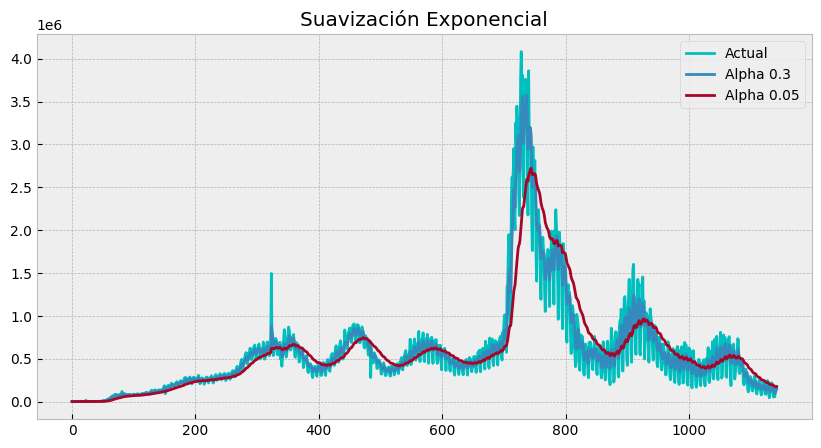

In [ ]:
plot_exponential_smoothing(world_daily_increase_df.data, [0.3, 0.05]) #Entre mas grande alpha, le estoy dando mas peso al error. Mientras menos, menos peso al error.
#El alpha lo escogemos nosotros

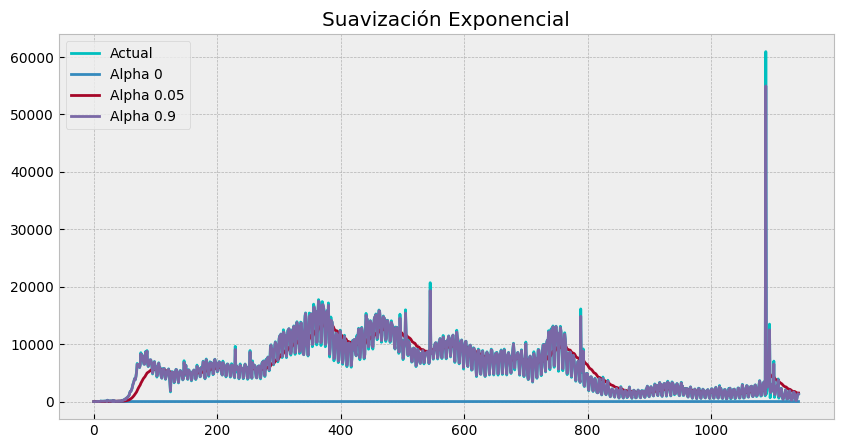

In [ ]:
plot_exponential_smoothing(world_daily_death_df.data, [0, 0.05, 0.9])

#Transformación de variable datos en índice

<Axes: xlabel='dates'>

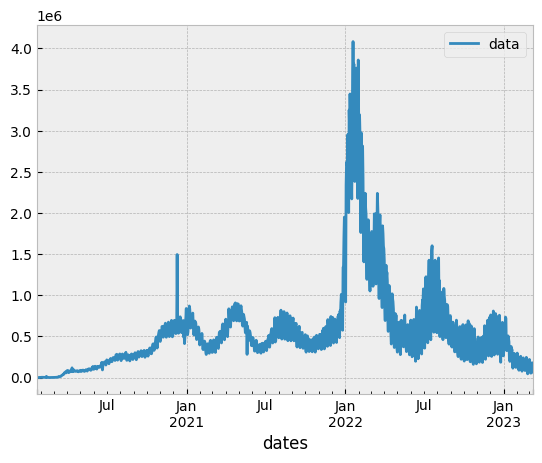

In [ ]:
world_daily_increase_df['dates'] = pd.to_datetime(world_daily_increase_df['dates'], format = '%m/%d/%y')
world_daily_increase_df.set_index('dates', inplace = True)
world_daily_increase_df.plot()

In [ ]:
alpha = 2/(len(world_daily_increase_df['data'] + 1)) #Forma de generar el alpha de forma no aleatoria
print(alpha)

0.0017497812773403325


In [ ]:
modeloSuavizacionSimple = SimpleExpSmoothing(world_daily_increase_df).fit(smoothing_level = 0.3)
ajusteExponencialSimple = modeloSuavizacionSimple.fittedvalues
pronosticos = modeloSuavizacionSimple.forecast(100)

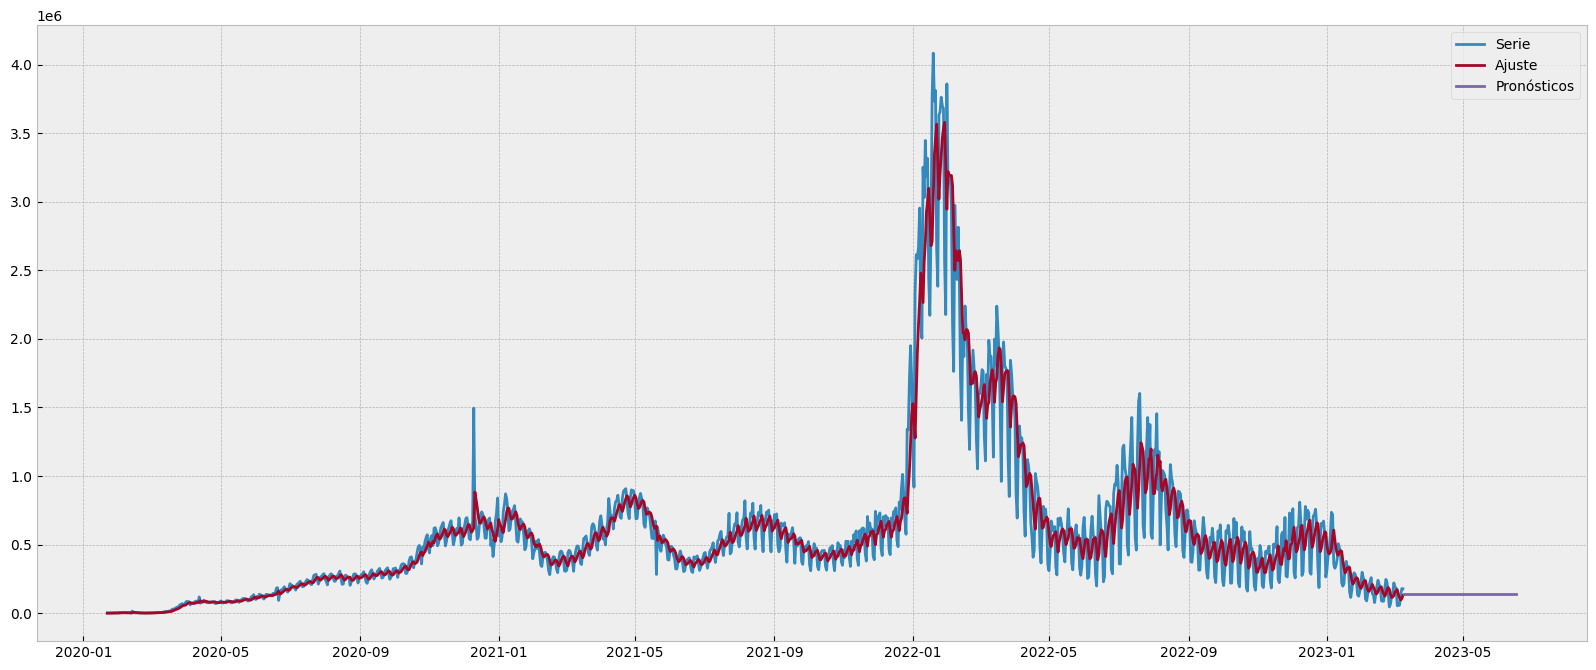

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(world_daily_increase_df, label='Serie')
plt.plot(ajusteExponencialSimple, label='Ajuste')
plt.plot(pronosticos, label='Pronósticos')
plt.legend()
plt.show()

In [ ]:
pronosticos

2023-03-10    142897.235727
2023-03-11    142897.235727
2023-03-12    142897.235727
2023-03-13    142897.235727
2023-03-14    142897.235727
                  ...      
2023-06-13    142897.235727
2023-06-14    142897.235727
2023-06-15    142897.235727
2023-06-16    142897.235727
2023-06-17    142897.235727
Freq: D, Length: 100, dtype: float64

In [ ]:
modelHoltWinters = ExponentialSmoothing(world_daily_increase_df, trend = 'add', seasonal = 'mul', seasonal_periods = 7).fit()
ajusteHoltWinters = modelHoltWinters.fittedvalues
pronosticoHoltWinters = modelHoltWinters.forecast(100)

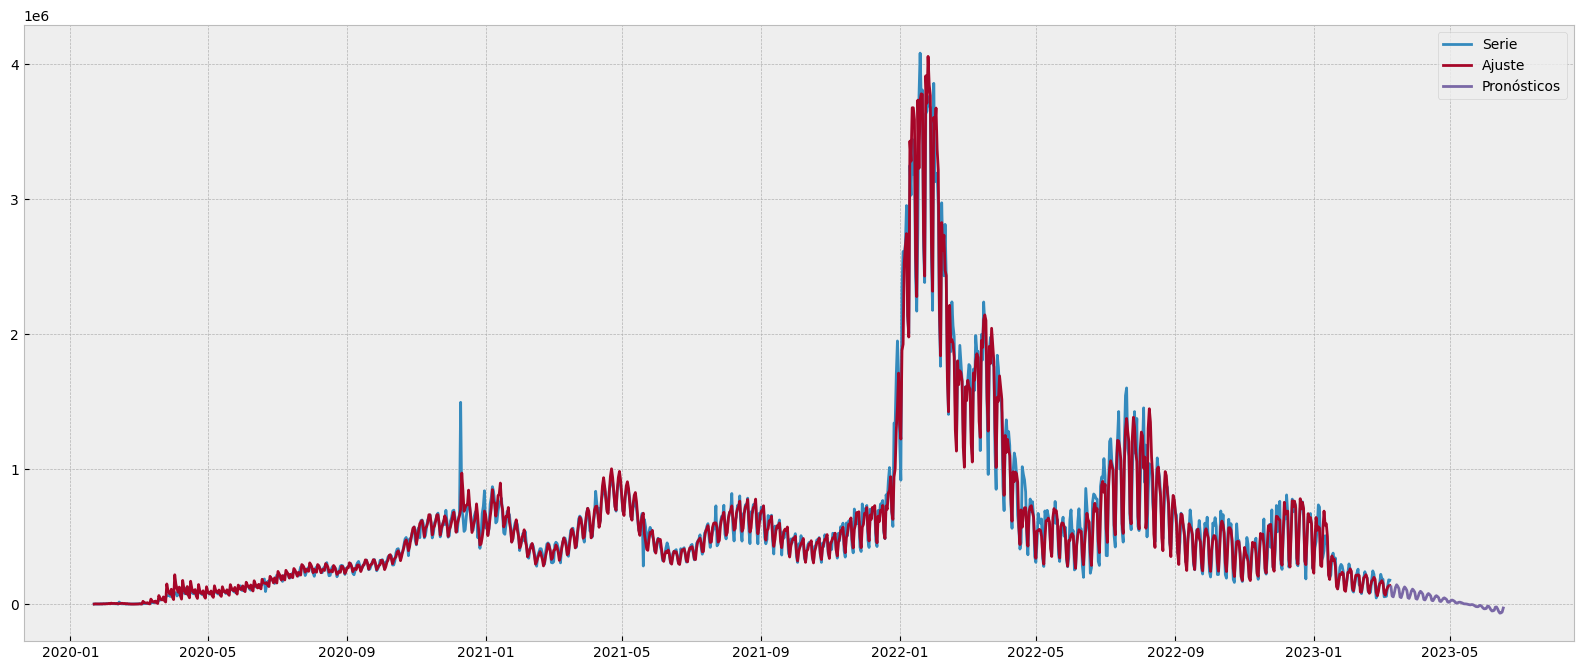

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(world_daily_increase_df, label='Serie')
plt.plot(ajusteHoltWinters, label='Ajuste')
plt.plot(pronosticoHoltWinters, label='Pronósticos')
plt.legend()
plt.show()